<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/NewReference(AutoEncoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import skimage.util.noise as noise #Denoise 패키지인 Sckit.image의 util모듈. return 값은 numpy로 다루는 ndarray임. https://scikit-image.org/docs/stable/api/skimage.util.html#random-noise 


In [4]:
transform=transforms.ToTensor()
dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform) #train_image와 train_label을 설치한다.

m=len(dataset)
train_set, val_set = torch.utils.data.random_split(dataset, [50000,10000])
test_set = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
num_workers=1
batch_size = 32

#random_plit하면 리스트형 generator로 만들어지는데 tensor가 아니므로 numpy로 변환 할 수 없는 문제와 다수의 List object는 numpy로 변하지 않는 문제 때문에 indice 차원으로 분리를 해줌. 
#출처 : https://stackoverflow.com/questions/64092369/validation-dataset-in-pytorch-using-dataloaders 

X_train_set = train_set.dataset.data[train_set.indices] #이미지 데이터
Y_train_set = train_set.dataset.targets[train_set.indices] # 정답 라벨

X_val_set = val_set.dataset.data[val_set.indices]
Y_val_set = val_set.dataset.targets[val_set.indices]

#for t in train_set:
#  t=torch.tensor(t) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환

In [6]:
val_set_arr= X_train_set.numpy()

In [7]:
test_set_arr = test_set.data.numpy()

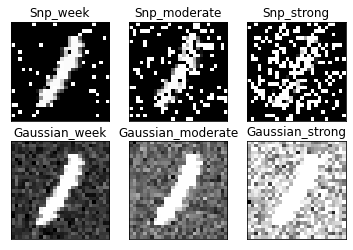

In [10]:
#Validation_set을 training_set에서 쪼개기
#Gaussian moderate와 strong이 큰 차이가 없으므로 값을 달리하기
#검증 데이터와 테스트 데이터의 양이 동일한 경우하거나 검증데이터가 테스트 데이터보다 더 많이 설정한다.


Snp_train_set_arr1 = noise.random_noise(train_set_arr,mode='s&p',amount=0.1) #함수 random_noise를 사용한다. speckle도 추가 가능
Snp_train_set_arr2 = noise.random_noise(train_set_arr,mode='s&p',amount=0.3)
Snp_train_set_arr3 = noise.random_noise(train_set_arr,mode='s&p',amount=0.5)

Snp_test_set_arr1 = noise.random_noise(test_set_arr,mode='s&p',amount=0.1) 
Snp_test_set_arr2 = noise.random_noise(test_set_arr,mode='s&p',amount=0.3)
Snp_test_set_arr3 = noise.random_noise(test_set_arr,mode='s&p',amount=0.5)

Gn_train_set_arr1 = noise.random_noise(train_set_arr,mode='gaussian',mean=0.2) #gaussian,speckle noise의 비율을 결정하는 파라미터인 mean이다. default는 0이다.
Gn_train_set_arr2 = noise.random_noise(train_set_arr,mode='gaussian',mean=0.5)
Gn_train_set_arr3 = noise.random_noise(train_set_arr,mode='gaussian',mean=0.9)

Gn_test_set_arr1 = noise.random_noise(test_set_arr,mode='gaussian',mean=0.2) 
Gn_test_set_arr2 = noise.random_noise(test_set_arr,mode='gaussian',mean=0.5)
Gn_test_set_arr3 = noise.random_noise(test_set_arr,mode='gaussian',mean=0.9)


titles = ['Snp_week', 'Snp_moderate', 'Snp_strong', 'Gaussian_week', 
          'Gaussian_moderate', 'Gaussian_strong']
images = [ Snp_train_set_arr1[0], Snp_train_set_arr2[0], Snp_train_set_arr3[0],
          Gn_train_set_arr1[0], Gn_train_set_arr2[0], Gn_train_set_arr3[0]]

for i in range(6):
  plt.subplot(2,3,i+1), plt.imshow(images[i],cmap='gray')
  plt.title(titles[i])
  plt.xticks([]), plt.yticks([]) #xticks?

#torch.from_numpy(img).float().div(255.0).unsqueeze(0)로 해결 하였습니다. 감사 합니다.

Snp_week_train = torch.from_numpy(Snp_train_set_arr1).float().div(255.0).unsqueeze(0)
Snp_moderate_train = torch.from_numpy(Snp_train_set_arr2)
Snp_strong_train= torch.from_numpy(Snp_train_set_arr3)

Gaussian_week_train = torch.from_numpy(Gn_train_set_arr1)
Gaussian_moderate_train = torch.from_numpy(Gn_train_set_arr2)
Gaussian_strong_train = torch.from_numpy(Gn_train_set_arr3)

Snp_week_test = torch.from_numpy(Snp_test_set_arr1)
Snp_moderate_test = torch.from_numpy(Snp_test_set_arr2)
Snp_strong_test = torch.from_numpy(Snp_test_set_arr3)

Gaussian_week_test = torch.from_numpy(Gn_test_set_arr1)
Gaussian_moderate_test = torch.from_numpy(Gn_test_set_arr2)
Gaussian_strong_test = torch.from_numpy(Gn_test_set_arr3)

Snp_week_train_loader = DataLoader(Snp_week_train,batch_size=batch_size,num_workers=num_workers)
Snp_week_test_loader = DataLoader(Snp_week_test,batch_size=batch_size,num_workers=num_workers)

Snp_moderate_train_loader = DataLoader(Snp_moderate_train,batch_size=batch_size,num_workers=num_workers)
Snp_moderate_test_loader = DataLoader(Snp_moderate_test,batch_size=batch_size,num_workers=num_workers)

Snp_strong_train_loader = DataLoader(Snp_strong_train,batch_size=batch_size,num_workers=num_workers)
Snp_strong_test_loader = DataLoader(Snp_strong_test,batch_size=batch_size,num_workers=num_workers)

[0.05235168 0.15124997 0.21005354 0.07850492 0.36978217 0.21522358
 0.1528273  0.09969646 0.24911582 0.18800999 0.06902092 0.10648762
 0.21517428 0.33307087 0.30977146 0.20442926 0.11009641 0.0469963
 0.28084103 0.1925698  0.17657422 0.13448992 0.05811751 0.12628361
 0.19885765 0.27420861 0.31241614 0.12607079]


In [27]:
class Encoder(nn.Module):   # resize(scale_down)으로 이미지의 크기를 줄여 나간다.
                            # information을 compression한다.
                            # torch.nn은 미니배치(다차원)만 지원한다.(=한 샘플의 미니배치들)
                            # nn.Moudule은 layer와 output을 반환하는 foward(input) method(멤버함수)가 있다.

  def __init__(self, encoded_space_dim,fc2_input_dim): #생성자 메서드(__init__)임. parameter로 
    super().__init__()

    self.encoder_cnn = nn.Sequential( #다중모듈을 single module로 만들어내는 nn.Sequential함수이다. 
        
        #입력 데이터 크기 channel = 1, width = 28, height = 28 [1,28,28]
        nn.Conv2d(1, 8, 3, stride=2, padding=1),    #Conv2d(,output_channel,filter_size,stride=1,padding=0) 
        #출력 데이터 크기 [8, 14, 14]               #https://machine-geon.tistory.com/46
        nn.ReLU(True), 

        #입력 데이터 크기 [8, 14, 14]   
        nn.Conv2d(8,16, 3, stride=2, padding=1), #Conv2d는 4차원 tensor를 입력으로 한다. Conv2d(nSamples,nChannels,Height,Width). 가상의 차원 추가방법은 input.unsqueeze(0)이다.
        #출력 데이터 크기 [16, 7, 7]
        nn.BatchNorm2d(16), #이거 하는 이유로는 Gradient Exploding(에러율이 폭등해서 Nan이 된다)을 막아서 train 과정을 안정화 시킨다. 결과적으로 학습이 안정적으로 여러 번 할 수 있게 되므로 학습이 가속화 됨 
        nn.ReLU(True),

        #입력 데이터 크기 [16, 7, 7]
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        #출력 데이터 크기 [32, 3, 3]
        nn.ReLU(True)
    )

    ##Flatten layer
    self.flatten = nn.Flatten(start_dim=1) # feature의 개수는  32X3X3 = 288이다.

    self.encoder_lin = nn.Sequential( #디코더에 넘겨줄 내부 차원을 128로 지정한다. 
        nn.Linear(3*3*32,fc2_input_dim), #Flatten_layer에 속한 288개의 feature를 128개의 열값으로 나누어서 흩뿌린다. 외부에서 지정해줘야 한다
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, encoded_space_dim) #128을 4개의 열값으로 나누어서 흩뿌린다. 
    )

  def forward(self, x): #출력
    x = self.encoder_cnn(x) 
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [28]:
class Decoder(nn.Module): # Upsampling으로 이미지의 크기를 키워 나간다. 보간 방법으로는 전통적인 bilineara, bicubic, Nearest등이 있고 최신으로는 CNN이 있다. 출처 : https://deep-mind-learning.tistory.com/36  
                          # information을 expansion한다.
                          # 코랩에 이미지 붙여넣는 방법!!!!: https://bskyvision.com/856 
                          
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__() #생성자를 만든다.
    self.decoder_lin = nn.Sequential( 
        nn.Linear(encoded_space_dim, fc2_input_dim), #encoder_lin으로 부터 받은 feature 4를 128로 늘려준다.
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, 3*3*32), #다시 flatten_layer의 128개를 Conv2d의 최종 출력 크기 256개로 동일하게 늘려서 feature를 분배해준다. 
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3)) #256개로 이루어진 1차원 벡터를 3차원으로 만들어준다.(다차원인 미니배치로 만들어준다)
    
    self.decoder_conv = nn.Sequential(  
        nn.ConvTranspose2d(32, 16, 3, #ConvTranpose2d통한 출력 공식 이미지 출처 : http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html 
        stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, #ConvTranspose에서 stride가 2면 이미지 너비X높이가 2배씩 늘어난다.
        padding=1, output_padding=1), #padding과 output_padding이 차이?
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2,
        padding=1, output_padding=1)  
    )
     
  def forward(self, x): 
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x) #마지막에 sigmoid를 넣어서 원래의 이미지로 복원한다.
    return x  

In [40]:
lr = 0.001
torch.manual_seed(0) #manual_seed로 랜덤 난수를 고정함.
d=4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128) #처음에 4차원으로 세팅함. 32,1,28,28로 입력값으로 입력시킬 예정이다. [batch,channel.height,width] 
ecoder = Decoder(encoded_space_dim=d, fc2_input_dim=128) #Encoder와 완전이 같은 이유가 뭐지?

In [41]:
im = test_set[0][0].unsqueeze(0) #입력할 이미지에 맨 처음에 1인 차원을 추가 해준다.
print(test_set[0][0].size())

a = im+torch.randn_like(im)*0.3
print(a)

print(im.size())


torch.Size([1, 28, 28])
tensor([[[[-2.6186e-01, -5.2741e-01,  1.4207e-01, -3.4364e-02, -8.2293e-01,
           -3.7285e-01, -1.8820e-01,  4.0052e-01, -1.9379e-01,  1.9511e-01,
            5.5844e-02,  1.5201e-01, -2.4522e-01, -1.7641e-01, -2.5315e-01,
           -1.7867e-01, -2.1425e-01, -1.4516e-01, -4.0096e-01,  7.6207e-02,
            2.9988e-01,  3.7973e-01, -1.2842e-03,  5.4212e-01,  4.1303e-01,
           -2.4690e-01, -3.0636e-01,  4.5861e-01],
          [-6.7076e-02, -1.4981e-01, -5.0485e-02,  4.1239e-02,  5.7786e-02,
           -4.0090e-02,  1.7192e-01,  5.4917e-01,  4.0920e-01,  4.1377e-01,
           -7.3474e-01,  1.7478e-01,  2.6263e-01,  2.3820e-01,  4.0751e-01,
           -2.1979e-02, -1.1016e-01,  3.2486e-01,  2.2441e-01,  1.3555e-01,
            8.9648e-02,  5.4989e-01, -2.0372e-01,  7.9197e-03,  2.4757e-01,
            1.2877e-01,  4.0095e-01,  4.0813e-02],
          [ 2.8814e-01,  5.3218e-01, -2.7910e-01, -9.0633e-03,  1.3595e-01,
           -8.3562e-02,  4.1258e-01,  

In [42]:
b = torch.clip(a, 0. , 1.)
print(b)
print(b.size())

tensor([[[[0.0000, 0.0000, 0.1421, 0.0000, 0.0000, 0.0000, 0.0000, 0.4005,
           0.0000, 0.1951, 0.0558, 0.1520, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0762, 0.2999, 0.3797, 0.0000, 0.5421,
           0.4130, 0.0000, 0.0000, 0.4586],
          [0.0000, 0.0000, 0.0000, 0.0412, 0.0578, 0.0000, 0.1719, 0.5492,
           0.4092, 0.4138, 0.0000, 0.1748, 0.2626, 0.2382, 0.4075, 0.0000,
           0.0000, 0.3249, 0.2244, 0.1355, 0.0896, 0.5499, 0.0000, 0.0079,
           0.2476, 0.1288, 0.4009, 0.0408],
          [0.2881, 0.5322, 0.0000, 0.0000, 0.1359, 0.0000, 0.4126, 0.2726,
           0.0000, 0.0000, 0.0762, 0.0000, 0.0914, 0.0000, 0.5176, 0.2502,
           0.0234, 0.3301, 0.3147, 0.1164, 0.0000, 0.5301, 0.0721, 0.0000,
           0.0000, 0.0000, 0.1256, 0.0000],
          [0.1789, 0.2824, 0.0000, 0.2299, 0.0000, 0.6975, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.1913, 0.0000, 0.0000, 0.0000, 0.6041,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [45]:
loss_fn = torch.nn.MSELoss()

#최적화에 들어가는건 변수(iterable, parameter)가 되야 한다. 출처 : https://pytorch.org/docs/stable/optim.html ??
#iterable이란 한 번에 하나의 member로 반환하는 object(객체)를 의미한다. iterator함수로 변환 가능함.
#list, str, tuple 같은 Sequence type. 배열은 아니더라도 dicdt, file ojbect, sequence semantic을 가진 __iter__() method, __getitem__() method가 구현 된 object. for문에서는 자동으로 iterator가 생성 된다.  출처 : https://technote.kr/325
#iterator의 정의. 데이터의 흐름(stream)으로 흐름 내에서 바로 다음에 처리해야 할 데이터를 기억하고 있음

params_to_optimize = [ #params_to_optimize를 통해서 encoder나 decoder 구조체를 optimizer용도의 파라미터로 변환 함.
  {'params' : encoder.parameters()},  #모델마다 각각의 learning_rate를 설정 할 수 있음
  {'params' : decoder.parameters()}   #모델명 뒤에 접근연산자와 함께 parameters()를 붙여야지 정상적으로 변환 된다.
]

#optimize 구성 전에 사전에 Cuda를 준비시켜야 함.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #torch.device("string") 함수로 사용 할 연산장치(cpu나 Gpu장치)를 설정한다. device 변수에 할당한다. 
print('Selected device : {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05) #overfitiing 방지 용도임. weight_decay로 최적화 할 때 L2 penalty를 부여해서 loss를 최소화 한다.(Lasso 정규화 참고?) 출처 : https://sanghyu.tistory.com/88?category=1120072

encoder.to(device) #encoder,decoder 모델에 데이터를 제공한다 model.to('cuda')를 통해서 가능함.
decoder.to(device) 

Selected device : {device}


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
#train실행하면서 발생되는 로스를 구하는 함수이다. 각기 다른 optimizer와 noise_factor를 적용 할 수 있음. 가우시안 노이즈, s&p를 달리 할 수 있을까?
def AE_train_epoch_den(encoder,decoder, device, input_dataloader, corrupted_dataloader,loss_fn, optimizer):
  encoder.train() #encoder 클래스를 인스턴스(메모리에 실어버림)화 시켜서 train mode로 실행한다.
  decoder.train()
  train_loss = [] #나중에 loss의 평균치를 구해야 하므로 공간을 미리 할당 시켜 둔다. 이거 리스트임(리스트는 대괄호 사용, 수정 가능). 튜플은 소괄호 사용 수정 불가
  
  #test_epoch_den과 달리 torch.no_grad()를 사용하지 않는다. 즉, gradient를 caculate 하는 곳임을 의미
  for image_batch,_ in input_dataloader, corrupted_dataloader: #데이타로더가 앞에는 데이터고 뒤에는 라벨인데 현재 비지도 학습이므로 사용하지 않는다.
    image_batch = image_batch.to(device) 
    encoded_data = encoder(image_batch) #여기에 원본이미지를 추후 넣을 수도 있겠음을 기억하자.
    decoded_data = decoder(encoded_data)
    DAE_loss = loss_fn(decoded_data, image_batch) #loss_fn의 반환 값이 loss산기록인지 확인하기 loss 비교는 복원 데이터와, 원본 이미지임
    
    optimizer.zero_grad() # 그래디언트를 초기화 한다. 출처 : https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
    loss.backward() #backward(역전파)를 이용해서 zero_grad로 만들어진 새로운 tensor공간에 할당 할 loss의 flossgradient를 계산한다.
    optimizer.step()#구한 gradient를 이용해서 weight를 update한다. loss.backward 실행 후 가능하다.

    print('\t partial train loss (single batch):f'%(loss.data)) # 현재 epoch에서의 손실율을 반환한다.
    train_loss.append(loss.detach().cpu().numpy())              # loss는 현재 GPU에 올라간 tensor이다. detach를 통해서 현재의 그래프(역전파 계산이 끝난 연산기록)에서 분리한 tensor를 반환시킨다. 
                                                                # (loss에서 따온)GPU메모리에 올려져 있는 tensor를 cpu 메모리에 복사시켜서 확인 할 수 있게 만든다.
                                                                # (cpu에 복사된)tensor를 numpy로 변환해서 반환 시킨다.(cpu tensor와 numpy array는 저장공간을 공유하는 장점. Gpu tensor는 공유 하지 않음)
                                                                # tesnor를 numpy로 변환시키기 위해서는 cpu 메모리에 존재해야 하므로 .cpu()>.numpy()이다.
                                                                # .cpu()를 .detach() 이전에 실행시키면 node를 만드는 gradient(edge)와 node(tensor)가 기록 된 graph를 반환 한다. 그런데 분리시키면 입력값인 node(tensor)만 반환 할 수 있다. 
                                                            
                                                            
  return np.mean(train_loss)


In [1]:
#train실행하면서 발생되는 로스를 구하는 함수이다. 각기 다른 optimizer와 noise_factor를 적용 할 수 있음. 가우시안 노이즈, s&p를 달리 할 수 있을까?
def DAE_train_epoch_den(encoder,decoder, device, dataloader,loss_fn, optimizer):
  encoder.train() #encoder 클래스를 인스턴스(메모리에 실어버림)화 시켜서 train mode로 실행한다.
  decoder.train()
  train_loss = [] #나중에 loss의 평균치를 구해야 하므로 공간을 미리 할당 시켜 둔다. 이거 리스트임(리스트는 대괄호 사용, 수정 가능). 튜플은 소괄호 사용 수정 불가
  
  #test_epoch_den과 달리 torch.no_grad()를 사용하지 않는다. 즉, gradient를 caculate 하는 곳임을 의미
  for image_batch,_ in dataloader: #데이타로더가 앞에는 데이터고 뒤에는 라벨인데 현재 비지도 학습이므로 사용하지 않는다.
    image_noisy = corrupted_dataloader.to(device) 
    encoded_data = encoder(image_noisy) #여기에 원본이미지를 추후 넣을 수도 있겠음을 기억하자.
    decoded_data = decoder(encoded_data)
    DAE_loss = loss_fn(decoded_data, image_noisy) #loss_fn의 반환 값이 loss산기록인지 확인하기 loss 비교는 복원 데이터와, 노이즈 데이터임
    
    optimizer.zero_grad() # 그래디언트를 초기화 한다. 출처 : https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
    loss.backward() #backward(역전파)를 이용해서 zero_grad로 만들어진 새로운 tensor공간에 할당 할 loss의 flossgradient를 계산한다.
    optimizer.step()#구한 gradient를 이용해서 weight를 update한다. loss.backward 실행 후 가능하다.

    print('\t partial train loss (single batch):f'%(loss.data)) # 현재 epoch에서의 손실율을 반환한다.
    train_loss.append(loss.detach().cpu().numpy())              # loss는 현재 GPU에 올라간 tensor이다. detach를 통해서 현재의 그래프(역전파 계산이 끝난 연산기록)에서 분리한 tensor를 반환시킨다. 
                                                                # (loss에서 따온)GPU메모리에 올려져 있는 tensor를 cpu 메모리에 복사시켜서 확인 할 수 있게 만든다.
                                                                # (cpu에 복사된)tensor를 numpy로 변환해서 반환 시킨다.(cpu tensor와 numpy array는 저장공간을 공유하는 장점. Gpu tensor는 공유 하지 않음)
                                                                # tesnor를 numpy로 변환시키기 위해서는 cpu 메모리에 존재해야 하므로 .cpu()>.numpy()이다.
                                                                # .cpu()를 .detach() 이전에 실행시키면 node를 만드는 gradient(edge)와 node(tensor)가 기록 된 graph를 반환 한다. 그런데 분리시키면 입력값인 node(tensor)만 반환 할 수 있다. 
                                                            
                                                            
  return np.mean(train_loss)


autograd에서의 detach, cpu, numpy 설명
출처 : https://byeongjo-kim.tistory.com/32 
https://pytorch.org/docs/stable/autograd.html#torch.Tensor.detach

In [13]:
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn, noise_factor):
    encoder.eval() #train 하지 않고 대신에 evaluation mode사용. 테스트 데이터만 가지고 비교 할 것이기 때문임
    decoder.eval() 
    with torch.no_grad(): #with을 써서 gradient 계산을 막아준다.(required_grad=False와 같음). 학습을 하지 않기 때문에 no.grad()일 수 있다.
      conc_out = [] #리스트 자료형 가져옴 
      conc_label = []
      for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor) #original image인 image_batch에 noise_factor를 추가하였다. add_noisy함수는 cuda가 적용이 안 되서 아래에서 쿠다를 적용시켜주는것인가? 아니면 그냥 초기화를 하는건가
        
         
        image_noisy = image_noisy.to(device) #여기에만 to.device를 추가해주는 이유로는 모든 cuda를 사용하는 입력데이터에는 적용이 필요함. encoder에 들어가기 전에 쿠다를 적용시켜 줌
       
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        conc_out.append(decoded_data.cpu()) #decoded_data를 cpu 메모리에 복사하고 이 값을 conc_out 변수에 객체를 추가한다. 
        conc_label.append(image_batch.cpu())  #원본이미지를 conc_label에 추가시켜준다. 쿠다에서 복사해온다.
                                              #문자열 추가함수 append이다. 텐서의 차원을 추가하려면 cat을 쓴다.

      conc_out = torch.cat(conc_out) #concatenate(텐서를 결합하는 함수)다. 반환은 당연히 텐서다. 차원증가와 함께 실제 값이 추가 된다. dim=0이 default이다.
      conc_label = torch.cat(conc_label)

      val_loss = loss_fn(conc_out, conc_label) # loss 비교는 원본이미지와 
    return val_loss.data #val_loss반환값이 test_epoch_den 함수인지 아니면 torch.no_grad()함수인지 모르겠다

In [16]:
def plot_ae_outputs_den(encoder, decoder, n=10, noise_factor m  ): #noise_factor를 다르게 줄 수 있는 부분!!!!!!!!!! Gaussian, S&P 추가하기
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy() #.target은 무슨 의미인가?
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2: # 나누기 후 소수점 부분을 버린다.
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

SyntaxError: ignored

In [ ]:
##Training Cycle
noise_factor = 0.3
num_epochs = 30
history_da = {'train_loss':[], 'val_loss':[]}
print(history_da)

In [ ]:
for epoch in range(num_epochs): #training하면서 몇 번의 epoch때 마다 검증데이터로 오차율?을 계산한다. 실제로 보정까지 하는지는 확인필요??
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, #쿠다를 사용한다.
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim, noise_factor=noise_factor) #여기도 noise_factor를 적용해줘야겠다.
    ### Validation  (use the testing function)
    val_loss = test_epoch_den( 
        encoder=encoder, 
        decoder=decoder, 
        device=device, #cuda를 사용한다.
        dataloader=valid_loader, #드디어 valid_loader 사용한다.
        loss_fn=loss_fn, noise_factor = noise_factor) #여기도 noise_factor 변경 필요
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder, decoder, noise_factor=noise_factor)

In [ ]:
#After training
test_epoch_den(encoder, decoder, device, test_loader, loss_fn).item()

In [ ]:
#before training
test_epoch_den(encoder, decoder, device, test_loader, loss_fn).item()

In [ ]:
def plot_reconstructed(decoder, r0=(-5,10), r1=(-5,10), n=10): #??
  plt.figure(figsize=(20,8,5))
  w = 28
  img = np.zeros((n*w,n*w))
  for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
      z = torch.Tensor([[x,y]]).to(device)
      x_hat = decoder(z)
      y_hat = x_hat.reshape(28, 28).to('cpu').detatch().numpy()
      img[(n-1-i)*w : (n-1-i+1), j*w:(j+1)*w] = x_hat
  plt.imshow(img,extent=[*r0, *r1], cmap = 'gist_gray') 

In [ ]:
encoded_sample = []
for sample in tqdm(test_dataset):
  img = sample[0].unsqueeze(0).to(device)
  label = sample[1]
  #Encoded image
  encoder.eval()
  with torch.no_grad():
    encoded_img = encoder(img)
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  encoded_sample['label'] = label
  encoded_samples.append(encoded_sample)